In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.ticker as ticker

In [2]:
# read in the data
integrals = pd.read_csv('../data/integrals_20170323.txt',sep=',',header=None)
integral_ranges = pd.read_csv('../data/coculture_peak_ranges.txt',sep=',')
master = pd.read_csv('../data/merged_metadata.txt',sep='\t')

In [3]:
# Add metabolite names to columns and merge the metadata with integrals
integrals.columns = integral_ranges['met_name']
mets = integrals.columns # grab metabolite names for future use
integrals['experiment_id'] = master['experiment_id']
all_data = pd.merge(master,integrals,on='experiment_id')

# remove unknown metabolites for this analysis
mets = [met for met in mets if met.find('unknown') < 0]


#remove non-growing samples
all_data = all_data.loc[~((all_data['Run'] == 2) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('500') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('492') > -1))]
# remove run 4
all_data = all_data.loc[~(all_data['Run'] == 4)]

In [4]:
# Set negative values as 0
all_data[mets] = all_data[mets].clip(0)

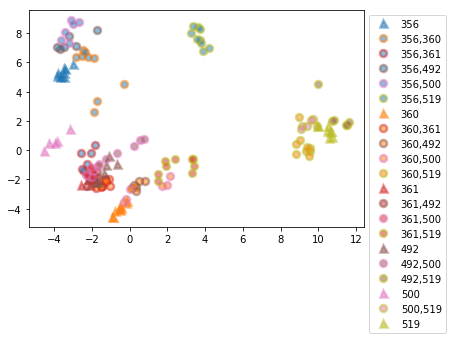

In [5]:
# Perform PCA using all monoculture samples, without blanks or 502, 
# and remove outliers for ASF500 and 519.
# Then, plot the co-culture samples in PCA space using the loadings.
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']

# keep a copy that contains the co-cultures for plotting
df_with_cocultures = df_for_pca.copy()
# filter out co-cultures for performing PCA
df_for_pca = df_for_pca.loc[[len(groupname) < 2 for groupname in df_for_pca['species'].str.split(',')]]
 
# create sklearn pipeline for scaling, performing PCA, and generating scores for each sample
pipe_w_scale = make_pipeline(StandardScaler(), PCA(n_components=2))
pipe_w_scale.fit(df_for_pca[mets])

pc1 = pipe_w_scale.transform(df_for_pca[mets])[:,0]
pc2 = pipe_w_scale.transform(df_for_pca[mets])[:,1]
pc1_with_cocultures = pipe_w_scale.transform(df_with_cocultures[mets])[:,0]
pc2_with_cocultures = pipe_w_scale.transform(df_with_cocultures[mets])[:,1]
# Add scores for each sample back to the dataframes
df_for_pca['PC1'] = pc1
df_for_pca['PC2'] = pc2
df_with_cocultures['PC1'] = pc1_with_cocultures
df_with_cocultures['PC2'] = pc2_with_cocultures

# get variance explained for PC1/PC2
pc1_var = pipe_w_scale.named_steps.pca.explained_variance_[0]
pc2_var = pipe_w_scale.named_steps.pca.explained_variance_[1]

# Generate colors for each species for plotting
cm = plt.get_cmap('tab10')
num_colors = 6
color_dict = {}
species = ['356','360','361','492','500','519']
i=0
for specie in species:
    color = cm(1.*i/num_colors)
    color_dict[specie] = color
    i+=1

# plot by species group. For monocultures, plot a triangle.
# for co-cultures, plot a circle with fill as species 1 and outline as species 2.
group_species = df_with_cocultures.groupby('species')
fig, ax = plt.subplots()
i = 0
for name, group in group_species:
    if len(name.split(',')) > 1:
        shape = 'o'
        species_1 = name.split(',')[0]
        species_2 = name.split(',')[1]
        color = color_dict[species_1]
        color2 = color_dict[species_2]
    else:
        shape = '^'
        color = color_dict[name]
        color2 = color
    ax.plot(group['PC1'],group['PC2'], marker=shape, linestyle='', ms=7, label=name,\
            markerfacecolor=color,markeredgecolor=color2,\
           markeredgewidth=2.5,alpha = 0.5)


ax.legend()
plt.legend(bbox_to_anchor=(1,1))

In [6]:
# The global PCA doesn't display the information we're interested in better than other figures.
# For communicating global differences across individual species, the heatmap does better because
# it can show both production and consumption info, whereas PCA loadings lack this information.
# For communicating the "mixing" and "emergent" effects of co-culture, PCA of individual pairings
# is much, much clearer than the global picture.

In [7]:
# PCA of coculture vs. monoculture metabolomics for select combos
def coculture_pca_plot(pca_species_1,pca_species_2,pca_dataframe,filename,met_names):

    pca_combo = pca_species_1 + ',' + pca_species_2
    df_for_pca = pca_dataframe.loc[(pca_dataframe['species'] == pca_species_1) | \
                              (pca_dataframe['species'] == pca_species_2) | \
                              (pca_dataframe['species'] == pca_combo)].copy()

    pipe_w_scale = make_pipeline(StandardScaler(), PCA(n_components=2))
    pipe_w_scale.fit(df_for_pca[met_names])

    pc1 = pipe_w_scale.transform(df_for_pca[met_names])[:,0]
    pc2 = pipe_w_scale.transform(df_for_pca[met_names])[:,1]
    df_for_pca['PC1'] = pc1
    df_for_pca['PC2'] = pc2
    pc1_var = pipe_w_scale.named_steps.pca.explained_variance_[0]
    pc2_var = pipe_w_scale.named_steps.pca.explained_variance_[1]

    colors = {'black':(0,0,0),
          'orange':(230.0/255.0,159.0/255.0,0.0),
          'sky_blue':(86.0/255.0,180.0/255.0,233.0/255.0),
          'bluish_green':(0.0,158.0/255.0,115.0/255.0),
          'yellow':(240.0/255.0,228.0/255.0,66.0/255.0),
          'blue':(0.0,114.0/255.0,178.0/255.0),
          'vermillion':(213.0/255.0,94.0/255.0,0.0),
          'reddish_purple':(204.0/255.0,121.0/255.0,167.0/255.0)}
    
    color_dict = {pca_species_1:colors['sky_blue'],\
                pca_species_2:colors['orange'],\
                pca_combo:colors['black']}

    fig, ax = plt.subplots()

    ax.scatter(df_for_pca['PC1'],df_for_pca['PC2'],facecolor = df_for_pca['species'].apply(lambda x: color_dict[x]), alpha = 0.5)
    ax.set_xlabel('PC1 (' + str(pc1_var)[:4] + '% variance explained)')
    ax.set_ylabel('PC2 (' + str(pc2_var)[:4] + '% variance explained)')
    ax.set_title('ASF'+pca_species_1 + ' and ASF'  + pca_species_2)
    tick_spacing = 3
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    fig.set_size_inches(3,3)
    plt.savefig(filename, bbox_inches='tight')
    pc1_loadings = dict(zip(pipe_w_scale.named_steps.pca.components_[0],met_names))
    pc2_loadings = dict(zip(pipe_w_scale.named_steps.pca.components_[1],met_names))
    return(pc1_loadings,pc2_loadings)


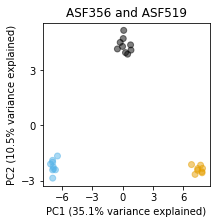

In [8]:
pca_species_1 = '356'
pca_species_2 = '519'
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']
filename = '../results/pca_'+pca_species_1+'_'+pca_species_2+'.svg'
pc1_loadings,pc2_loadings = coculture_pca_plot(pca_species_1=pca_species_1,pca_species_2=pca_species_2,\
                   pca_dataframe=df_for_pca,filename=filename,\
                  met_names=mets)

In [9]:
# inspect the loadings for the emergent principle component
pc2_loadings

{-0.28529872901787551: 'Serine',
 -0.27822131036047337: 'Leucine',
 -0.24964717418933455: 'Cystine',
 -0.23731583532839953: 'Threonine',
 -0.19038095359270638: 'Valine',
 -0.1902221818016645: 'Isoleucine',
 -0.15791595880049097: 'Uracil',
 -0.15757095601162852: 'Lactose',
 -0.15526404512742778: 'Nicotinamide',
 -0.15295345524035719: 'Trehalose',
 -0.14122825594650379: 'Adenosine',
 -0.13830371096773597: 'Alanine',
 -0.13580894197683027: 'Lactate',
 -0.10336476249921105: 'Asparagine',
 -0.081060392885804952: 'Aspartate',
 -0.07901056093148659: 'Ethanol',
 -0.073214165220850766: 'Uridine',
 -0.068516346870267822: 'Betaine',
 -0.065993684189958213: 'Cytidine',
 -0.058308460233432981: '2-Oxoisocaproate',
 -0.052830624484999644: 'Pyroglutamate',
 -0.047506320516286407: 'Isopropanol',
 -0.046088123969078056: 'Tyrosine',
 -0.043491932203748994: 'UMP',
 -0.035175142835209852: 'Adenine',
 -0.031847553096304562: 'Formate',
 -0.022802708715255617: 'Tryptophan',
 -0.0048009103706905167: 'AMP',
 0.

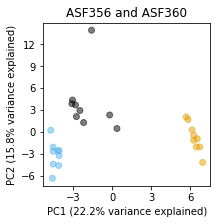

In [10]:
pca_species_1 = '356'
pca_species_2 = '360'
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']
filename = '../results/pca_'+pca_species_1+'_'+pca_species_2+'.svg'
pc1_loadings,pc2_loadings = coculture_pca_plot(pca_species_1=pca_species_1,pca_species_2=pca_species_2,\
                   pca_dataframe=df_for_pca,filename=filename,\
                  met_names=mets)

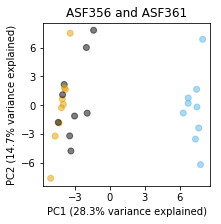

In [11]:
pca_species_1 = '356'
pca_species_2 = '361'
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']
filename = '../results/pca_'+pca_species_1+'_'+pca_species_2+'.svg'
pc1_loadings,pc2_loadings = coculture_pca_plot(pca_species_1=pca_species_1,pca_species_2=pca_species_2,\
                   pca_dataframe=df_for_pca,filename=filename,\
                  met_names=mets)

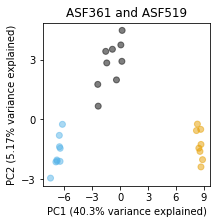

In [14]:
pca_species_1 = '361'
pca_species_2 = '519'
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']
filename = '../results/pca_'+pca_species_1+'_'+pca_species_2+'.svg'
pc1_loadings,pc2_loadings = coculture_pca_plot(pca_species_1=pca_species_1,pca_species_2=pca_species_2,\
                   pca_dataframe=df_for_pca,filename=filename,\
                  met_names=mets)

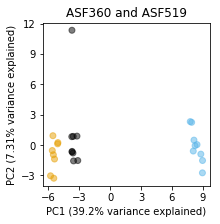

In [13]:
pca_species_1 = '360'
pca_species_2 = '519'
df_for_pca = all_data.loc[all_data['species'] != '0'].copy()
df_for_pca = df_for_pca.loc[df_for_pca['species'].str.find('502') < 0]
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '123B']
df_for_pca = df_for_pca.loc[df_for_pca['experiment_id'] != '121C']
filename = '../results/pca_'+pca_species_1+'_'+pca_species_2+'.svg'
pc1_loadings,pc2_loadings = coculture_pca_plot(pca_species_1=pca_species_1,pca_species_2=pca_species_2,\
                   pca_dataframe=df_for_pca,filename=filename,\
                  met_names=mets)